In [3]:
import yfinance as yf
import pandas as pd

aapl = yf.Ticker("AAPL")
msft = yf.Ticker("MSFT")
goog = yf.Ticker("GOOG")
amzn = yf.Ticker("AMZN")
tsla = yf.Ticker("TSLA")

In [4]:
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]
long_term_data = yf.download(tickers, start="2015-01-01", end="2024-01-01", auto_adjust=False)
adj_close = long_term_data["Adj Close"]
medium_term_data = yf.download(tickers, start="2021-01-01", end="2024-01-01", auto_adjust=False)
adj_close.describe()
#task 1

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOG,MSFT,TSLA
count,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000
mean,81.394710,91.950540,73.063479,154.516907,102.886245
std,55.990879,48.654536,36.298158,99.658478,110.936400
min,20.604078,14.347500,24.377237,34.437160,9.578000
25%,32.814688,44.303625,41.515254,59.182469,16.670500
50%,51.220840,90.691998,59.376663,127.528828,23.160666
75%,139.017635,133.230000,104.133980,244.037388,214.290005
max,196.256561,186.570496,149.587067,377.077881,409.970001


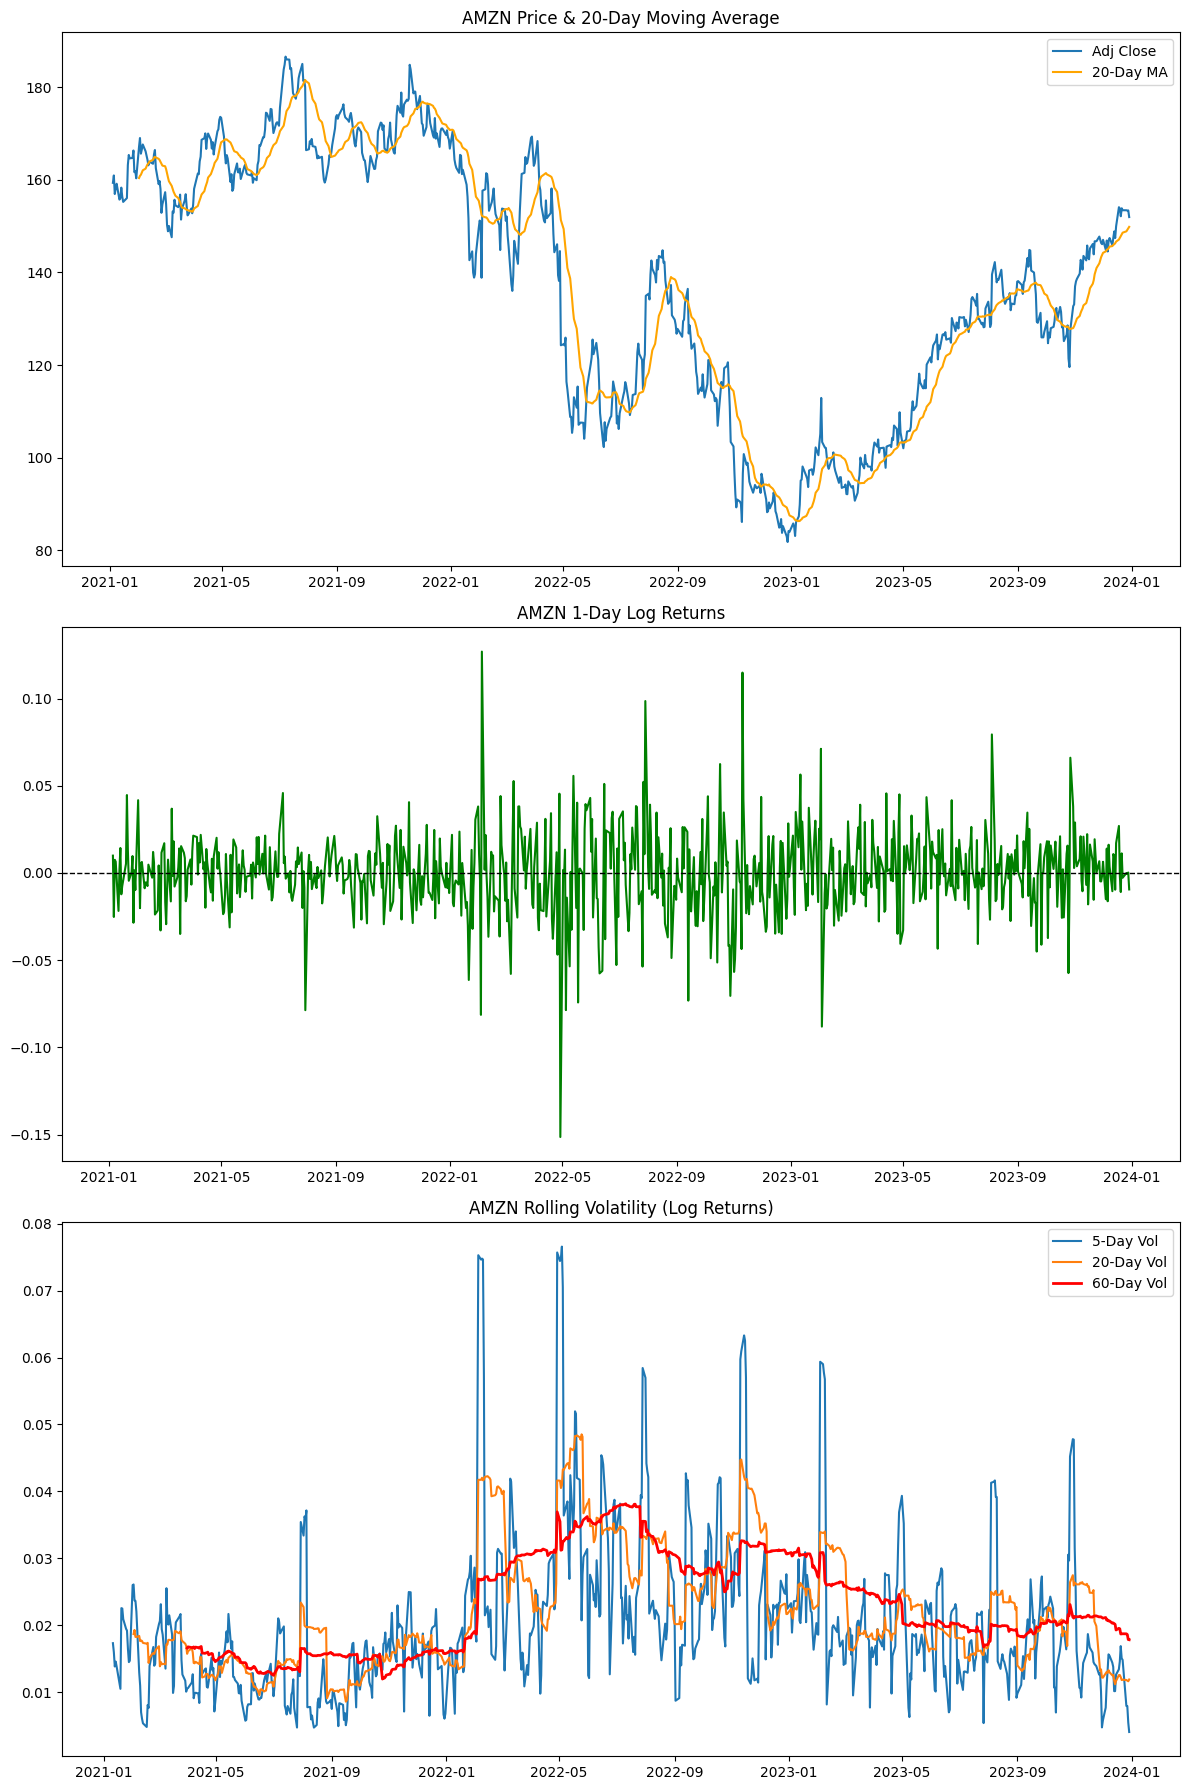

In [5]:
import numpy as np
asset = 'AMZN'
mt_price = medium_term_data['Adj Close'][asset]

simple_1d = mt_price.pct_change(1)
simple_5d = mt_price.pct_change(5)
simple_20d = mt_price.pct_change(20)

log_1d = np.log(mt_price / mt_price.shift(1))
log_5d = np.log(mt_price / mt_price.shift(5))
log_20d = np.log(mt_price / mt_price.shift(20))

vol_5d = log_1d.rolling(window=5).std()
vol_20d = log_1d.rolling(window=20).std()
vol_60d = log_1d.rolling(window=60).std()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

axes[0].plot(mt_price, label='Adj Close')
axes[0].plot(mt_price.rolling(window=20).mean(), label='20-Day MA', color='orange')
axes[0].set_title(f'{asset} Price & 20-Day Moving Average')
axes[0].legend()

axes[1].plot(log_1d, color='green')
axes[1].set_title(f'{asset} 1-Day Log Returns')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)

axes[2].plot(vol_5d, label='5-Day Vol')
axes[2].plot(vol_20d, label='20-Day Vol')
axes[2].plot(vol_60d, label='60-Day Vol', color='red', linewidth=2)
axes[2].set_title(f'{asset} Rolling Volatility (Log Returns)')
axes[2].legend()

plt.tight_layout()
plt.show()
#task 2
#Analysis -
# When the price crosses above the 20-day moving average, it often signals a bullish trend, while crossing below indicates a bearish trend. 
# high  volatility correlates with price drops

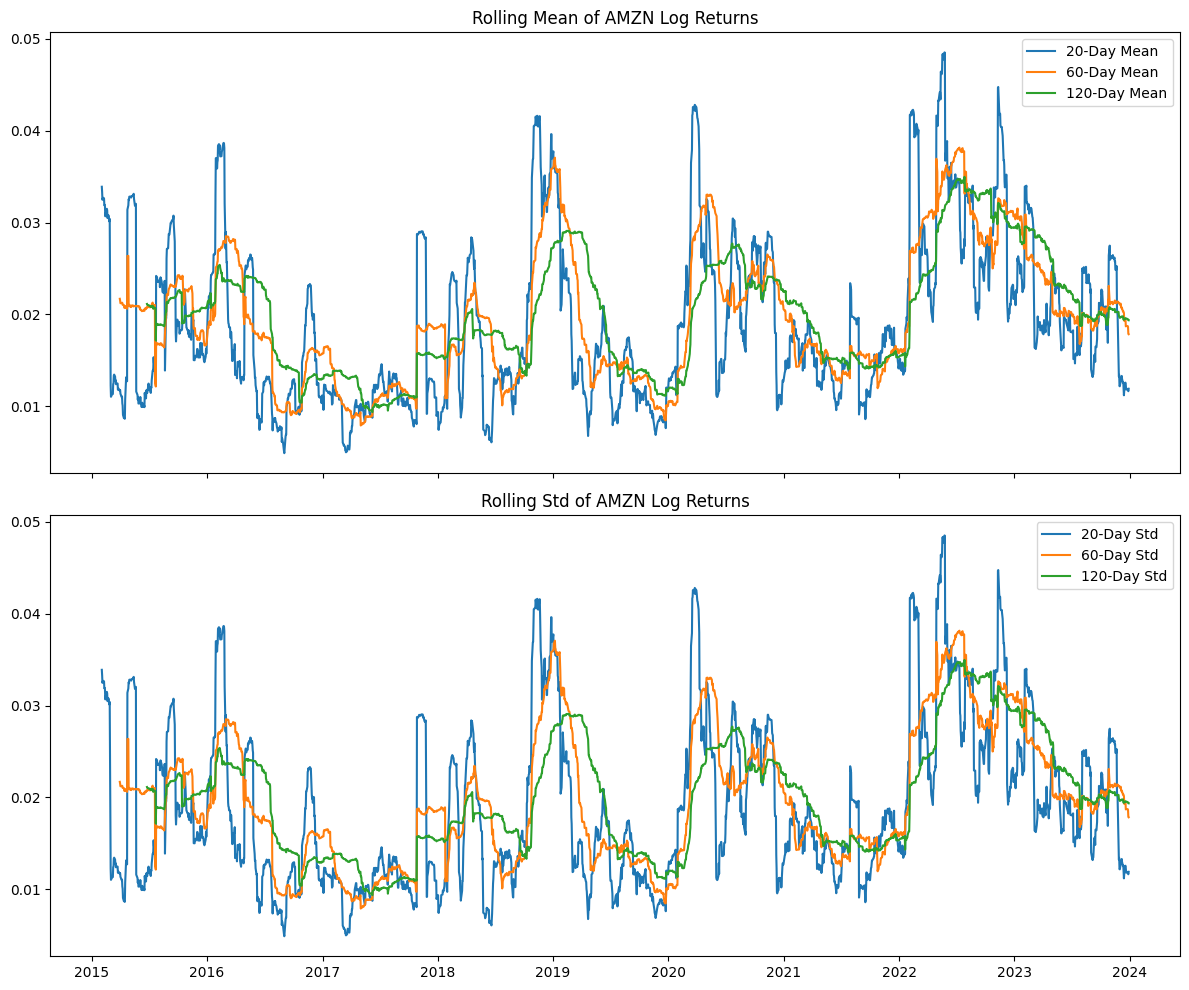

In [6]:
lt_log_returns = np.log(adj_close[asset] / adj_close[asset].shift(1)).dropna()
windows = [20, 60, 120]

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for w in windows:
    axes[0].plot(lt_log_returns.rolling(w).std(), label=f'{w}-Day Mean')
axes[0].set_title(f'Rolling Mean of {asset} Log Returns')
axes[0].legend()

for w in windows:
    axes[1].plot(lt_log_returns.rolling(w).std(), label=f'{w}-Day Std')
axes[1].set_title(f'Rolling Std of {asset} Log Returns')
axes[1].legend()

plt.tight_layout()
plt.show()
#task 3

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(lt_log_returns)
p_value = result[1]

print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Result: The series is Stationary (Reject H0)")
else:
    print("Result: The series is Non-Stationary (Fail to reject H0)")
#task 3

p-value: 3.767663242790805e-29
Result: The series is Stationary (Reject H0)


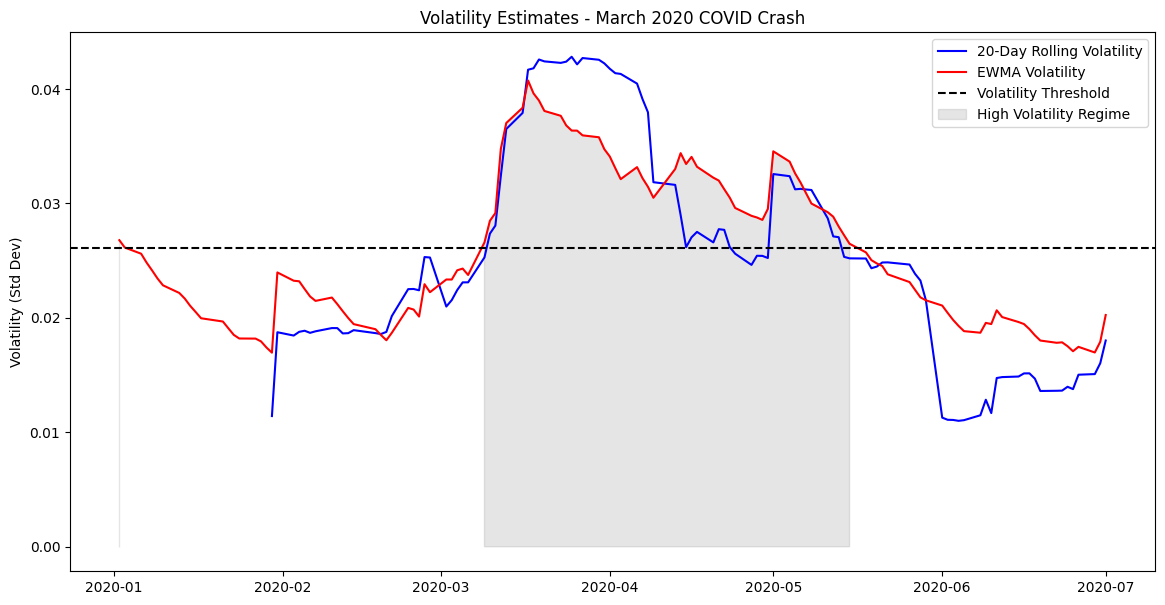

In [8]:
covid_data = lt_log_returns.loc['2020-01-01':'2020-07-01']

roll_vol = covid_data.rolling(window=20).std()

alplha = 0.06
ewma_var = (covid_data ** 2).ewm(alpha=alplha, adjust = False).mean()
ewma_vol = np.sqrt(ewma_var)

threshold = ewma_vol.quantile(0.60)

plt.figure(figsize=(14, 7))
plt.plot(roll_vol, label='20-Day Rolling Volatility', color='blue')
plt.plot(ewma_vol, label='EWMA Volatility', color='red')

plt.axhline(threshold, color='black', linestyle='--', label='Volatility Threshold')
plt.fill_between(ewma_vol.index, 0, ewma_vol, where=(ewma_vol > threshold), color='gray', alpha=0.2, label='High Volatility Regime')
plt.title('Volatility Estimates - March 2020 COVID Crash')
plt.ylabel('Volatility (Std Dev)')
plt.legend()
plt.show()
#Analysis -
# 20-Day rolling volatility is smoother
# EWMA reacted faster to the volatility spike in March 2020 since it even more weight to recent data
# For risk management during crises, EWMA is preferable due to its responsiveness
#Task 4

Horizon    | Skew       | Kurtosis       
----------------------------------------
Daily      | -0.1632    | 4.5046         
Weekly     | 0.0779     | 1.3051         
Monthly    | 0.3941     | 0.6035         


C:\Users\abiji\AppData\Local\Temp\ipykernel_34180\2042703943.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = daily_prices.resample('M').last()


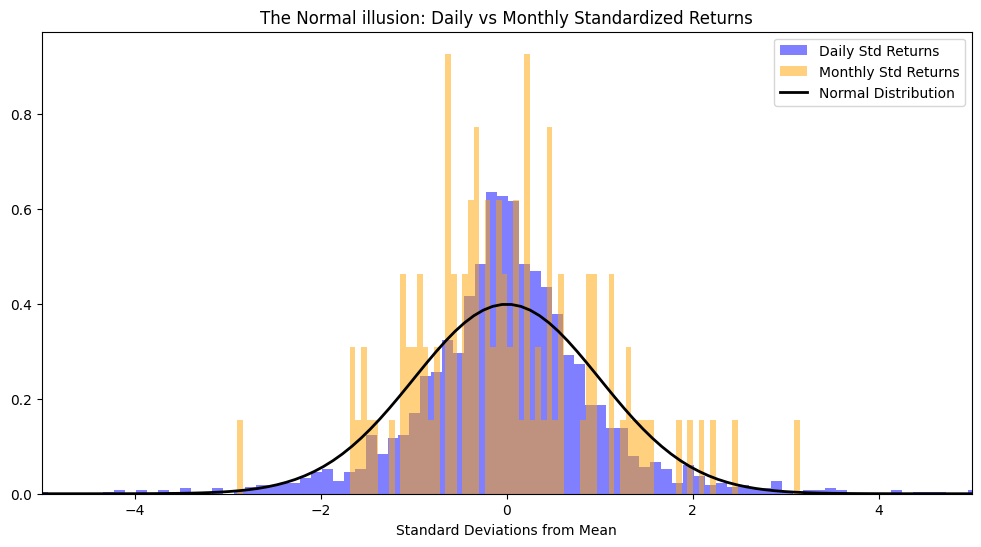

In [9]:
from scipy.stats import skew, kurtosis
asset = 'TSLA'

daily_prices = long_term_data['Adj Close'][asset]
weekly_prices = daily_prices.resample('W').last()
monthly_prices = daily_prices.resample('M').last()

daily_log_returns = np.log(daily_prices / daily_prices.shift(1)).dropna()
weekly_log_returns = np.log(weekly_prices / weekly_prices.shift(1)).dropna()
monthly_log_returns = np.log(monthly_prices / monthly_prices.shift(1)).dropna()
horizons = [('Daily', daily_log_returns), ('Weekly', weekly_log_returns), ('Monthly', monthly_log_returns)]

print(f"{'Horizon':<10} | {'Skew':<10} | {'Kurtosis':<15}")
print("-" * 40)

for name, data in  horizons:
    s = skew(data)
    k = kurtosis(data)
    print(f"{name:<10} | {s:<10.4f} | {k:<15.4f}")

daily_std = (daily_log_returns - daily_log_returns.mean()) / daily_log_returns.std()
monthly_std = (monthly_log_returns - monthly_log_returns.mean()) / monthly_log_returns.std()

plt.figure(figsize=(12, 6))

plt.hist(daily_std, bins=100, alpha=0.5, label='Daily Std Returns', color='blue', density=True)
plt.hist(monthly_std, bins=100, alpha=0.5, label='Monthly Std Returns', color='orange', density=True)

x = np.linspace(-5, 5, 100)
plt.plot(x, (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x**2), label='Normal Distribution', color='black', lw=2)

plt.title('The Normal illusion: Daily vs Monthly Standardized Returns')
plt.xlabel('Standard Deviations from Mean')
plt.xlim(-5, 5)
plt.legend()
plt.show()
#Analysis -
# Daily returns exhibit higher kurtosis and skewness compared to monthly returns, indicating more extreme values and asymmetry.
#Task 5


In [10]:
asset = 'NVDA'
birth_date = '2005-01-06'

nvda_data = yf.download(asset, start=birth_date, auto_adjust=False)
nvda_prices = nvda_data['Adj Close']

price_then = nvda_prices.iloc[0]
price_now = nvda_prices.iloc[-1]

investment = 1000

shares_bought = investment / price_then
current_value = shares_bought * price_now

rtx_4090_price = 1600
num_gpus = current_value // rtx_4090_price

print(f"Number of RTX 4090s: {int(num_gpus)}")
#Task 6

[*********************100%***********************]  1 of 1 completed

Number of RTX 4090s: 692



C:\Users\abiji\AppData\Local\Temp\ipykernel_34180\963052838.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"Number of RTX 4090s: {int(num_gpus)}")


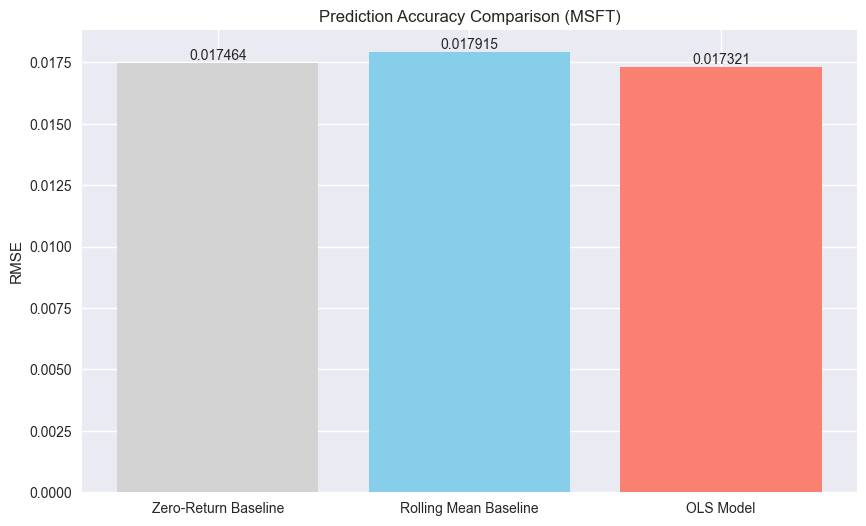

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

asset = 'MSFT'

prices = long_term_data['Adj Close'][asset]
returns = prices.pct_change().dropna()

def create_features(returns):
    df = pd.DataFrame(returns.values, index=returns.index, columns=['r_t'])
    df['r_t_lag1'] = df['r_t'].shift(1)
    df['rolling_mean_20'] = df['r_t'].rolling(window=20).mean()
    df['rolling_vol_20'] = df['r_t'].rolling(window=20).std()
    df['momentum_5'] = df['r_t'].rolling(window=5).apply(lambda x: (1 + x).prod() - 1)
    df['target'] = df['r_t'].shift(-1)
    return df.dropna()

features_df = create_features(returns)

def zero_return_predictor(X):
    return np.zeros(len(X))

def calculate_rmse(y_true, y_pred):
    if len(y_true) == 0: return 0
    return np.sqrt(mean_squared_error(y_true, y_pred))

def walk_forward_evaluation(df, model, initial_train_size):
    predictions = []
    actuals = []
    feature_cols = ['r_t', 'r_t_lag1', 'rolling_mean_20', 'rolling_vol_20', 'momentum_5']
    
    if len(df) <= initial_train_size:
        initial_train_size = int(len(df) * 0.7)
        print(f"Warning: Data too small. Adjusted train size to {initial_train_size}")

    for t in range(initial_train_size, len(df)):
        train = df.iloc[:t]
        test = df.iloc[t:t+1]
        
        X_train, y_train = train[feature_cols], train['target']
        X_test, y_test = test[feature_cols], test['target']
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        predictions.append(pred[0])
        actuals.append(y_test.values[0])
        
    return np.array(actuals), np.array(predictions), initial_train_size

ols_model = LinearRegression()
actuals, preds_ols, final_train_size = walk_forward_evaluation(features_df, ols_model, initial_train_size=252)

test_df = features_df.iloc[final_train_size:]
preds_zero = zero_return_predictor(test_df)
preds_rolling = test_df['rolling_mean_20'].values

metrics = {
    "Zero-Return Baseline": calculate_rmse(actuals, preds_zero),
    "Rolling Mean Baseline": calculate_rmse(actuals, preds_rolling),
    "OLS Model": calculate_rmse(actuals, preds_ols)
}

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=['lightgrey', 'skyblue', 'salmon'])
plt.ylabel('RMSE')
plt.title(f'Prediction Accuracy Comparison ({asset})')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.6f}', ha='center', va='bottom')

plt.show()